# Accessing CDS services with Python 
## ISM*@ST on 24/08/20

Katharina Lutz

## Before we get started
### More resources 
This is a collection of links, where you can find more information:
 - Relevant Python Packages:
     - [`astroquery`](https://astroquery.readthedocs.io/en/latest/)
     - [`pyVO`](https://pyvo.readthedocs.io/en/latest/#)
     - [`MOCpy`](https://cds-astro.github.io/mocpy/)
     - [`ipyaladin`](https://github.com/cds-astro/ipyaladin)
 - AstroBetter posts on: [ipyaladin](https://www.astrobetter.com/blog/2020/05/04/the-cds-and-python-i-explore-the-sky-with-ipyaladin/), [MOCs](https://www.astrobetter.com/blog/2020/06/01/the-cds-and-python-ii-to-cover-or-not-to-cover-mocs-to-the-rescue/), [VizieR & XMatch](https://www.astrobetter.com/blog/2020/06/29/the-cds-and-python-iii-vizier-xmatch-20k-catalogues-and-tables-at-your-fingertips/) and [SIMBAD](https://www.astrobetter.com/blog/2020/07/06/the-cds-and-python-iv-simbad-the-yellow-pages-of-astronomical-sources/)
 - [Classic VO tutorials](http://www.euro-vo.org/index25a9.html?q=science/scientific-tutorials) translated to [Python](https://github.com/cds-astro/tutorials) (in progress)
 
### Importing packages

In [1]:
from astropy.table import Table
from astropy.io import fits
from astropy import coordinates
from astropy.wcs import WCS
import astropy.units as u
import astropy.visualization as ap_vis

from astroquery.vizier import Vizier
from astroquery.cds import cds
from astroquery.simbad import Simbad

import pyvo

import ipyaladin.aladin_widget as ipyal
import mocpy
from urllib.parse import quote

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r3ww2m4c because the default path (/home/klutz/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Overview of CDS services

 - <img src="Images/logo_simbad.png" alt="SIMBAD" style="width:40px; display: inline-block;"/> **SIMBAD**: <br>
 a bibliographic database containing interesting astronomical objects that have been studied in the literature. Look here for information on single objects, where are they located, what type of object is it, which paper mentions this object? <br>
 $\rightarrow$ **`astroquery.simbad`** and **`pyVO`**
 - <img src="Images/logo_vizier.png" alt="VizieR" style="width:40px; display: inline-block;"/> **VizieR**: <br>
 a database of catalogues and tables and their associated data. VizieR hosts both reference catalogues from large surveys at all wavelengths (2MASS, GAIA, NVSS, ...) and tables from papers. In addition data (images or spectra) associated with some tables are also provided. <br>
 $\rightarrow$ **`astroquery.vizier`** and **`pyVO`**
 - <img src="Images/xmatch2.png" alt="XMatch" style="width:40px; display: inline-block;"/> **XMatch**: <br>
 quick spatial cross matches between tables. These could be your own tables, any VizieR table or all of SIMBAD. <br>
 $\rightarrow$ **`astroquery.xmatch`**
 - <img src="Images/logo_aladin.png" alt="Aladin" style="width:40px; display: inline-block;"/> **Aladin & AladinLite**: <br>
 simple and fast acces to all large imaging surveys, which are provided in the form of HiPS.  <br>
 $\rightarrow$ **`ipyaladin`** (in development **`hips2fits`**)
 - **MOC**: <br>
 coverage maps, which allow for description of arbitrary patches on the sky, and quick unions or intersections inbetween these patches.  <br>
 $\rightarrow$  **`MOCpy`** and **`astroquery.cds`**

## Cautionary note before we get started:
Running queries in a loop might make our servers feel like you are attempting a DDoS attack ;) The `query_region` functions in the `astroquery` modules usually take lists of coordinates as input. An other option is to add a little `time.sleep(3)` in your loop, which makes the script wait between each step. 

## Science setting for today
We are looking for galaxies sufficient auxiliary data to study the distribution of the dust to atomic gas ratio. 

The steps we are going to take are the following:
 - Find all those galaxies that are within the observing footprints of GALEX, DES or SDSS, WISE and Herschel.
 - Quickly visualise these galaxies and their location on the sky
 - Pick one of these galaxies and get tabular data from VizieR for this galaxy
 - Pick one of these galaxies and search the associated data in the VizieR for HI data
 - Compile a list of bibliographic references for this galaxy

## Get coverage maps and compute their interesection
First we get the multiorder coverage (MOC) maps of different surveys. These MOCs can be used to describe any arbitrary patch on the sky. You could actually create MOCs just based on [polygons](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_polygon) or your favourite [set of images](https://cds-astro.github.io/mocpy/stubs/mocpy.MOC.html#mocpy.MOC.from_fits_images), but here we are interested in the footprints of particular surveys or observations. These MOCs are stored on the CDS MOCServer and can be obtained with the `astroquery.cds` module. 

We know we want FUV imaging data from GALEX and F475W imaging data from HST, but we don't know what the data sets are called. So we first query the MOC server to get metadata for all data sets, which have IDs that contain some buzzwords. 

In [2]:
info_galex = cds.find_datasets(meta_data="ID=*GALEX*")
info_herschel = cds.find_datasets(meta_data="ID=*HERSCHEL*")
info_wise = cds.find_datasets(meta_data="ID=*WISE*")
info_des = cds.find_datasets(meta_data="ID=*DES*")
info_sdss = cds.find_datasets(meta_data="ID=*SDSS*")

Generally, you get a lot of meta data for each of these datasets:

In [3]:
info_galex

hips_service_url_5,obs_description,hips_service_url_2,t_min,hips_builder,client_category,hips_progenitor_url,obs_collection,hips_release_date,hips_service_url_4,hips_pixel_cut,bib_reference_url,hips_order,t_max,hips_status_1,hips_tile_format,hipsgen_params,obs_initial_fov,hips_initial_fov,moc_sky_fraction,ID,hips_service_url_1,hips_copyright,hips_creation_date,dataproduct_type,obs_copyright,hips_frame,bib_reference,hips_status_3,hips_status,obs_copyright_url,hips_creator,obs_ack,em_max,moc_access_url,hips_tile_width,hips_initial_ra,hips_estsize,hipsgen_date,hips_status_2,hips_pixel_scale,moc_order,client_sort_key,obs_initial_dec,hips_service_url_3,obs_regime,hips_status_4,hips_pixel_bitpix,hips_order_min,hips_service_url,hips_status_5,client_application,obs_initial_ra,prov_progenitor,TIMESTAMP,hips_initial_dec,hips_rgb_blue,dataproduct_subtype,obs_title,hips_version,hips_rgb_red,creator_did,em_min
str47,str1109,str57,float64,str22,str14,str61,str41,str17,str53,str11,str50,float64,float64,str24,str8,str68,float64,float64,float64,str24,str71,str12,str17,str5,str287,str10,str19,str26,str26,str27,str16,str493,float64,str63,float64,float64,float64,str17,str26,float64,float64,str8,float64,str58,str2,str24,float64,float64,str54,str24,object,float64,str12,float64,float64,str61,str5,str51,float64,str48,str30,float64
--,"From its launch into low-Earth orbit on April 28, 2003 the GALEX NUV camera operated almost continuously. The Project suspended operations of the FUV camera following an electrical overcurrent in May 2009. GALEX data products include a series of all sky surveys and deep sky surveys in the imaging mode, and partial surveys in the near and far UV spectroscopic modes. The principal imaging studies are the Nearby Galaxy Survey (NGS), Deep (DIS), Medium (MIS), and All Sky Imaging Surveys (AIS). The GALEX GR6 direct imaging data release are to be delivered to MAST between April and June 2010. The grism data release will occur shortly thereafter. The most notable changes between GR6 and GR4/5 include changes to the bandmerged source catalog (-mcat.fits). The Project has removed 26 columns which are either redundant or of questionable quality. These include the ""BEST"" and ""ISOCOR"" fluxes and magnitudes. The Project has also added 53 columns, mostly FUV measurements using the NUV source position. Significant updates and improvements have been made to the calibrations used for the GR6 data reductions.",http://alaskybis.u-strasbg.fr/GALEX/GR6-03-2014/AIS-FD,55287.0,Aladin/HipsGen v10.123,Image/UV/GALEX,http://alasky.u-strasbg.fr/GALEX/GR6-03-2014/AIS-FD/HpxFinder,GALEX Allsky Imaging Survey (AIS) FUV,2019-05-05T06:11Z,http://hips.canfar.net/CDS_P_GALEXGR6_AIS_FUV,0 0.003,http://cdsads.u-strasbg.fr/abs/2014AdSpR..53..900B,8.0,55348.0,public mirror unclonable,png fits,out=/asd-volumes/sc1-asd-volume10/GALEX/GR6-03-2014/AIS-FD UPDATE,1.0921117184376416e-07,1.0921117184376416e-07,0.6821,CDS/P/GALEXGR6/AIS/FUV,https://irsa.ipac.caltech.edu/data/hips/CDS/GALEX/GR6-03-2014/AIS-FD,CNRS/Unistra,2014-04-18T18:04Z,image,"Material credited to STScI on this site was created, authored, and/or prepared for NASA under Contract NAS5-26555. Unless otherwise specifically stated, no claim to copyright is being asserted by STScI and it may be freely used as in the public domain in accordance with NASA's contract.",equatorial,2014AdSpR..53..900B,public mirror clonableOnce,public master clonableOnce,http://galex.stsci.edu/GR6/,CDS (P.Fernique),We acknowledge the contribution of the JHU Sloan Digital Sky Survey group to the development of this site. Many of its features were inspired by the look and feel of the SkyServer. A special thanks goes to Tamas Budavari for his help with the SDSS-GALEX matching and to Wil O'Mullane for his help with the CASJobs site setup and configuration. We also acknowledge Randy Thompson (MAST) for providing IDL IUEDAC routines and Mark Siebert for providing IDL routines to generate tile JPEG images.,1.786e-07,http://alas

For the time being we are just happy to see the ID and and a descriptopn of the content

In [4]:
info_galex['ID', 'obs_title']

ID,obs_title
str24,str51
CDS/P/GALEXGR6/AIS/FUV,GALEX GR6 AIS (until March 2014)- Far UV
CDS/P/GALEXGR6/AIS/NUV,GALEX GR6 AIS (until March 2014)- NEAR UV
CDS/P/GALEXGR6/AIS/color,GALEX GR6 AIS (until March 2014)- Color composition


In [5]:
info_herschel['ID', 'obs_title']

ID,obs_title
str30,str34
ESAVO/P/HERSCHEL/PACS-color,Herschel PACS (color composition)
ESAVO/P/HERSCHEL/PACS100,Herschel PACS 100 micron
ESAVO/P/HERSCHEL/PACS100norm,PACS100norm
ESAVO/P/HERSCHEL/PACS160,Herschel PACS 160 micron
ESAVO/P/HERSCHEL/PACS160norm,PACS160norm
ESAVO/P/HERSCHEL/PACS70,Herschel PACS 70 micron
ESAVO/P/HERSCHEL/PACS70norm,PACS70norm
ESAVO/P/HERSCHEL/PACS_RGB_norm,PACS_RGB_norm
ESAVO/P/HERSCHEL/SPIRE-250,SPIRE250


In [6]:
info_wise['ID', 'obs_title']

ID,obs_title
str20,str70
CDS/P/NEOWISER/Color,"NEOWISER color Red (W2) , Blue (W1)"
CDS/P/NEOWISER/W1,NEOWISER W1
CDS/P/NEOWISER/W2,NEOWISER W2
CDS/P/WISE/W1,WISE W1 (3.4um)
CDS/P/WISE/W2,WISE W2 (4.6um)
CDS/P/WISE/W3,WISE W3 (12um)
CDS/P/WISE/W4,WISE W4 (22um)
CDS/P/WISE/WSSA/12um,Diffuse dust 12um WSSA (Meisner & Finkbeiner 2013)
CDS/P/allWISE/W1,AllWISE W1 (3.4um) from raw Atlas Images


In [7]:
info_des['ID', 'obs_title']

ID,obs_title
str26,str27
CDS/P/DES-DR1/Y,DES-DR1 Y
CDS/P/DES-DR1/g,DES-DR1 g
CDS/P/DES-DR1/i,DES-DR1 i
CDS/P/DES-DR1/r,DES-DR1 r
CDS/P/DES-DR1/z,DES-DR1 z
NOAO/P/DES/DR1/LIneA-color,DES DR1 LIneA color
cds/P/DES-DR1/ColorIRG,DES-DR1 color (I-R-G bands)


In [8]:
info_sdss['ID', 'obs_title']

ID,obs_title
str25,str64
CDS/J/ApJ/749/10/SDSS-obs,"SDSS observations of Kuiper belt objects (Ofek, 2012) (SDSS-obs)"
CDS/P/HLA/SDSSg,HLA-SDSSg : F475W
CDS/P/HLA/SDSSr,HLA-SDSSr : F625W and F622W
CDS/P/HLA/SDSSz,HLA-SDSSz : F850LP
CDS/P/HST/SDSSg,HST-SDSSg incudes the following filters: F475W
CDS/P/HST/SDSSr,HST-SDSSr includes the following filters: F625W and F622W
CDS/P/HST/SDSSz,HST-SDSSz includes the following filters: F850LP
CDS/P/SDSS9/color,SDSS9 color
CDS/P/SDSS9/color-alt,"SDSS9 color (g, r, i CDS color composition)"


Cool, new we know more about these datasets, let's get their coverage map.

In [9]:
moc_galex = cds.find_datasets(meta_data="ID=CDS/P/GALEXGR6/AIS/*UV", return_moc=True)
moc_sdss = cds.find_datasets(meta_data="ID=CDS/P/SDSS9/*", return_moc=True)
moc_wise = cds.find_datasets(meta_data="ID=CDS/P/allWISE/W*", return_moc=True)
moc_pacs = cds.find_datasets(meta_data="ID=ESAVO/P/HERSCHEL/PACS*", return_moc=True)
moc_spire = cds.find_datasets(meta_data="ID=ESAVO/P/HERSCHEL/SPIRE*", return_moc=True)
moc_des = cds.find_datasets(meta_data="ID=CDS/P/DES-DR1/*", return_moc=True)

In [10]:
moc_dict = {'GALEX': moc_galex, 'SDSS': moc_sdss, 
            'WISE': moc_wise, 'PACS': moc_pacs, 'SPIRE': moc_spire, 
            'DES': moc_des}

And we can visualise these coverage maps:

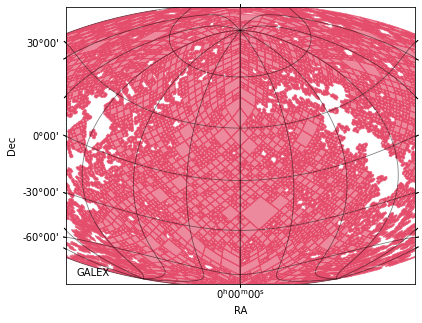

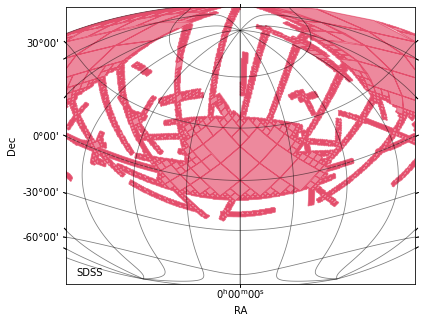

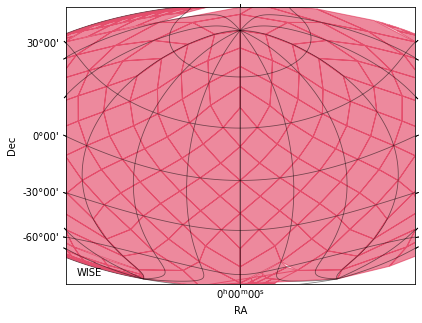

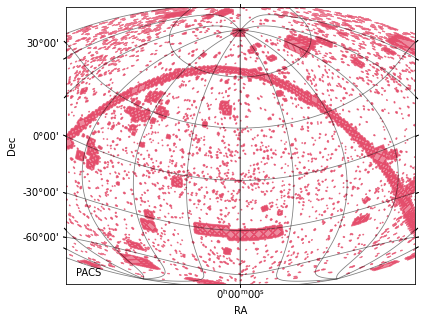

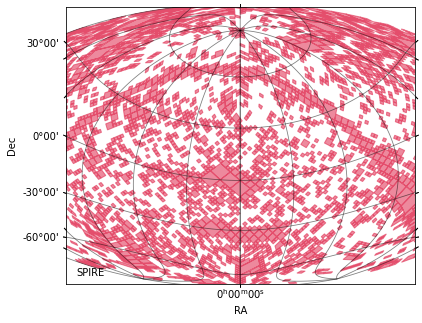

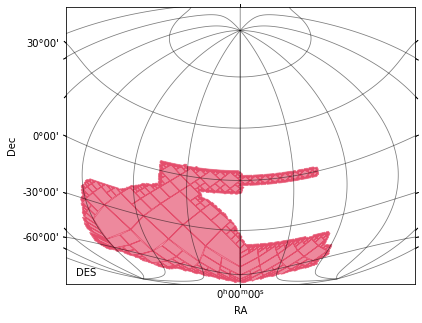

In [11]:
for survey in moc_dict.keys():
    fig = plt.figure(figsize=(6.3, 5.0))
    with mocpy.World2ScreenMPL(fig, 
             fov=200 * u.deg,
             center=coordinates.SkyCoord(0, 20, unit='deg', frame='icrs'),
             coordsys="icrs",
             rotation=coordinates.Angle(0, u.degree),
             projection="AIT") as wcs:
        ax = fig.add_axes([0.17, 0.17, 0.77, 0.77], projection=wcs)
        moc_dict[survey].fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="crimson")
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        lon, lat = ax.coords[0], ax.coords[1]
        lon.set_major_formatter('hh:mm:ss')
        lat.set_major_formatter('dd:mm')
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        lon.set_ticks(spacing=2 * u.hourangle)
        ax.coords.grid(color='black', linestyle='solid', alpha=0.5)
        ax.text(0.03, 0.03, survey, color='black', transform=ax.transAxes)

Now our idea was to get those regions on the sky that are either observed by SDSS or DES AND that are observed by all other surveys. To describe these regions with MOCs, we first build the union of SDSS and DES and then calculate the intersection between all remaining surveys

In [12]:
moc_final = moc_sdss.union(moc_des)
for survey in moc_dict.keys():
    if survey in ['SDSS', 'DES']: 
        continue
    print('Forming intersection with: ', survey)
    moc_final = moc_final.intersection(moc_dict[survey])

Forming intersection with:  GALEX
Forming intersection with:  WISE
Forming intersection with:  PACS
Forming intersection with:  SPIRE


and just a final look at the resulting shape:

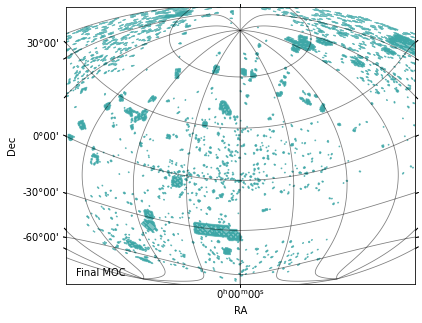

In [13]:
fig = plt.figure(figsize=(6.3, 5.0))
with mocpy.World2ScreenMPL(fig, 
         fov=200 * u.deg,
         center=coordinates.SkyCoord(0, 20, unit='deg', frame='icrs'),
         coordsys="icrs",
         rotation=coordinates.Angle(0, u.degree),
         projection="AIT") as wcs:
    ax = fig.add_axes([0.17, 0.17, 0.77, 0.77], projection=wcs)
    moc_final.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="darkcyan")
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter('hh:mm:ss')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
    lon.set_ticks(spacing=2 * u.hourangle)
    ax.coords.grid(color='black', linestyle='solid', alpha=0.5)
    ax.text(0.03, 0.03, 'Final MOC', color='black', transform=ax.transAxes)

Yep, that is a bit patchy, but this describes the regions on the sky we wanted and MOC is a great way to do this. 

## Get a catalogue from VizieR

In [14]:
catalog_list_dustpedia = Vizier.find_catalogs('Dustpedia')
for k, v in catalog_list_dustpedia.items():
    print(k, ': ', v.description)

J/A+A/609/A37 :  875 nearby galaxies multiwavelength photometry (Clark+, 2018)
J/A+A/622/A132 :  Dust emission profiles of DustPedia galaxies (Mosenkov+, 2019)
J/A+A/623/A5 :  DustPedia metallicities and HI masses (De Vis+, 2019)


/usr/local/lib/python3.6/dist-packages/astropy/io/votable/converters.py:757: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return value.tostring()


In [15]:
vizir_dustpedia = Vizier(row_limit=-1)
results = vizir_dustpedia.get_catalogs('J/A+A/609/A37')
results

/usr/local/lib/python3.6/dist-packages/astropy/io/votable/converters.py:757: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return value.tostring()


TableList with 4 tables:
	'0:J/A+A/609/A37/sample' with 16 column(s) and 875 row(s) 
	'1:J/A+A/609/A37/apphot' with 61 column(s) and 875 row(s) 
	'2:J/A+A/609/A37/irasphot' with 9 column(s) and 875 row(s) 
	'3:J/A+A/609/A37/plnkphot' with 16 column(s) and 875 row(s) 

This is a list of `astropy` tables , which you can just use as any other `astropy` table.

In [16]:
dustpedia_sample = results[0]
dustpedia_sample['Name', 'RAJ2000', 'DEJ2000']

Name,RAJ2000,DEJ2000
,deg,deg
bytes23,float64,float64
ESO149-013,0.69450,-52.77158
NGC0007,2.08695,-29.91534
ESO410-005,3.88020,-32.18061
IC0010,5.09625,59.29310
NGC0115,6.69330,-33.67698
ESO410-012,7.07520,-27.98335
NGC0131,7.41045,-33.25987
UGC00300,7.51740,3.51291


Since positions of the galaxies in Dustpedia are given in the catalogue we can filter the catalogue to only show galaxies within the MOC. 

In [17]:
indexes = moc_final.contains(dustpedia_sample['RAJ2000'].T * u.deg, 
                             dustpedia_sample['DEJ2000'].T * u.deg)
filtered_dustpedia = dustpedia_sample[indexes]
filtered_dustpedia

Name,RAJ2000,DEJ2000,MType,MClass,D25,Incl,HV,HVcorr,Distcorr,Dist0,HVH,DistH,Dist0H,Dist,SimbadName
,deg,deg,,,arcmin,deg,km / s,km / s,Mpc,Mpc,km / s,Mpc,Mpc,Mpc,
bytes23,float64,float64,float32,bytes4,float32,float64,int16,int32,float64,float32,int32,float64,float64,float64,bytes23
ESO410-005,3.88020,-32.18061,0.4,S0-a,1.2882,51.799999,159,164,2.23921,1.90,36,0.49153,1.94089,1.94089,ESO410-005
NGC0115,6.69330,-33.67698,3.9,SBbc,2.0893,74.400002,1825,1821,24.86346,29.98,1828,24.95904,28.70782,28.70782,NGC0115
ESO410-012,7.07520,-27.98335,4.7,Sc,1.4125,82.800003,1545,1539,21.01311,--,1544,21.08138,--,21.01311,ESO410-012
NGC0131,7.41045,-33.25987,3.0,SBb,1.8197,73.800003,1410,1399,19.10158,--,1416,19.33370,--,19.10158,NGC0131
ESO410-018,8.54625,-30.77392,8.9,SABm,1.5488,32.299999,1582,1571,21.45003,19.00,1584,21.62753,--,19.00000,ESO410-018
NGC0148,8.56455,-31.78615,-2.0,S0,1.9953,90.000000,1516,1504,20.53523,26.23,1574,21.49099,--,26.23000,NGC0148
NGC0150,8.56455,-27.80370,3.4,SBb,3.5481,66.900002,1584,1574,21.49099,21.01,1584,21.62753,21.08630,21.08630,NGC0150
ESO411-013,11.77665,-31.58135,9.0,SBm,1.2303,90.000000,1760,1742,23.78482,--,1760,24.03058,--,23.78482,ESO411-013


Alternatively we can query Vizier only within the MOC. (Currently this functionality is located within the MOCPy package but it might move over to astroquery at some point.)

In [18]:
filtered_dustpedia_2 = moc_final.query_vizier_table('J/A+A/609/A37/sample', max_rows=100000)
filtered_dustpedia_2

/usr/local/lib/python3.6/dist-packages/astropy/io/votable/converters.py:757: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return value.tostring()


_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,MType,MClass,D25,Incl,HV,HVcorr,Distcorr,Dist0,HVH,DistH,Dist0H,Dist,SimbadName
deg,deg,,deg,deg,,,arcmin,deg,km / s,km / s,Mpc,Mpc,km / s,Mpc,Mpc,Mpc,
float64,float64,object,float64,float64,float32,bytes4,float32,float64,int16,int32,float64,float32,int32,float64,float64,float64,object
3.8802000,-32.1806100,ESO410-005,3.88020,-32.18061,0.4,S0-a,1.2882,51.799999,159,164,2.23921,1.90,36,0.49153,1.94089,1.94089,ESO410-005
6.6933000,-33.6769800,NGC0115,6.69330,-33.67698,3.9,SBbc,2.0893,74.400002,1825,1821,24.86346,29.98,1828,24.95904,28.70782,28.70782,NGC0115
7.0752000,-27.9833500,ESO410-012,7.07520,-27.98335,4.7,Sc,1.4125,82.800003,1545,1539,21.01311,--,1544,21.08138,--,21.01311,ESO410-012
7.4104500,-33.2598700,NGC0131,7.41045,-33.25987,3.0,SBb,1.8197,73.800003,1410,1399,19.10158,--,1416,19.33370,--,19.10158,NGC0131
8.5462500,-30.7739200,ESO410-018,8.54625,-30.77392,8.9,SABm,1.5488,32.299999,1582,1571,21.45003,19.00,1584,21.62753,--,19.00000,ESO410-018
8.5645500,-31.7861500,NGC0148,8.56455,-31.78615,-2.0,S0,1.9953,90.000000,1516,1504,20.53523,26.23,1574,21.49099,--,26.23000,NGC0148
8.5645500,-27.8037000,NGC0150,8.56455,-27.80370,3.4,SBb,3.5481,66.900002,1584,1574,21.49099,21.01,1584,21.62753,21.08630,21.08630,NGC0150
11.7766500,-31.5813500,ESO411-013,11.77665,-31.58135,9.0,SBm,1.2303,90.000000,1760,1742,23.78482,--,1760,24.03058,--,23.78482,ESO411-013


Just a quick recap in between: we have seen, how we can
 - check the spatial coverage of different surveys. 
 - find intersections and unions of these coverage maps. 
 - find tables in VizieR.
 - download tables from VizieR.
 - filter tables to find those entries that are located within a MOC. 
 
## Visualise sources

One option is the AladinLite widget for Jupyter notebooks:

In [19]:
aladin= ipyal.Aladin(survey='cds/P/DES-DR1/ColorIRG', target='NGC289', fov=0.5)
aladin

Aladin(fov=0.5, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

In [20]:
aladin.add_table(filtered_dustpedia)

In [21]:
aladin.target = 'M101'

Another option is to use HiPS, which Josh mentioned the other day. HiPS is a way of organising image, cube and catalogue data in a hierarchical way. The main principle is, the more you zoom in the more you see. All the surveys shown in the AladinLite widget above are organised as HiPS. Since all HiPS are saved in Healpix format getting cutouts is quite easy. There is a [webpage](http://alasky.u-strasbg.fr/hips-image-services/hips2fits), which has more information and a module in astroquery is under development. For the time being, we can use the following workaround:

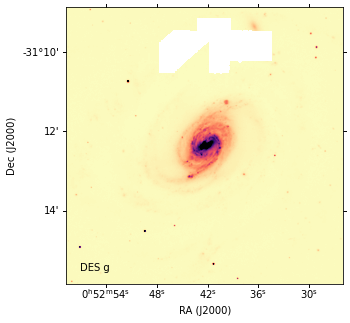

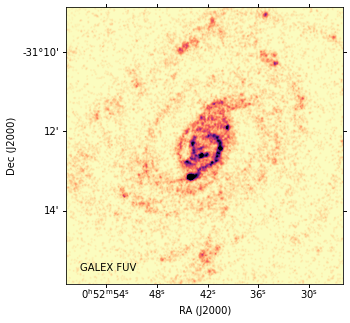

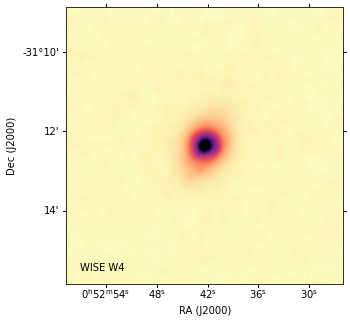

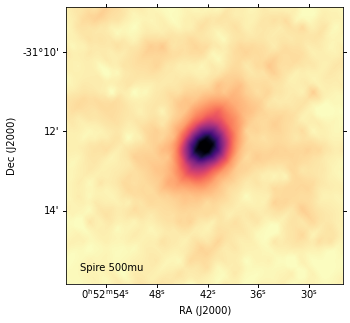

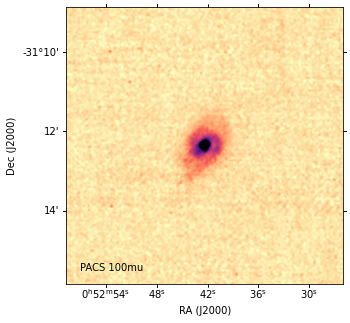

In [22]:
selected_hips = {'DES g': 'CDS/P/DES-DR1/g', 'GALEX FUV': 'CDS/P/GALEXGR6/AIS/FUV', 
                 'WISE W4': 'CDS/P/allWISE/W4', 'Spire 500mu': 'ESAVO/P/HERSCHEL/SPIRE-500', 
                 'PACS 100mu': 'ESAVO/P/HERSCHEL/PACS100'}
# Field of view in deg, here we want 7arcmin
fov = 7.0 / 60.
# Numbers of pixel with pixelsize of 0.6 arcsec
width = int(round(fov * 3600. / 0.6))
height = int(round(fov * 3600. / 0.6))
# Central coordinates 
sc = coordinates.SkyCoord(ra=13.17645, dec=-31.20581, unit=u.deg)
ra = sc.icrs.ra.deg
dec = sc.icrs.dec.deg

interval = ap_vis.AsymmetricPercentileInterval(1.0, 99.9)

for survey in selected_hips.keys():
    # get the image
    hips = selected_hips[survey]
    url = 'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?' + \
          'hips={0}&width={1:d}&height={2:d}&fov={3:.4f}&'.format(quote(hips), width, height, fov)  + \
          'projection=TAN&coordsys=icrs&ra={0:.5f}&dec={1:.5f}'.format(ra, dec)
    ima = fits.open(url)
    
    # plot the image
    wcs = WCS(ima[0].header)
    fig = plt.figure(figsize=(6.3, 5.0))
    ax = fig.add_axes([0.17, 0.17, 0.77, 0.77], 
                      projection=wcs)
    vmin, vmax = interval.get_limits(ima[0].data)
    ax.imshow(ima[0].data, origin='lower',
              vmin=vmin, vmax=vmax, 
              cmap=mpl.cm.magma_r)
    # take care of axis labels ect.
    imsize = fov / (ima[0].header['CDELT2'])
    central_pix = wcs.wcs_world2pix(np.array([[ra], [dec]]).T, 0)
    ax.set_ylim(central_pix[0][1] - 0.5 * imsize,
                central_pix[0][1] + 0.5 * imsize)
    ax.set_xlim(central_pix[0][0] - 0.5 * imsize,
                central_pix[0][0] + 0.5 * imsize)
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter('hh:mm:ss')
    lat.set_major_formatter('dd:mm')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel('Dec (J2000)')
    ax.text(0.05, 0.05, '{}'.format(survey), color='black',
            transform=ax.transAxes)
    # save the image and close it
    ima.writeto('test_{}.fits'.format(survey), overwrite=True)
    ima.close()

This is still relavtively new technology and things are evolving. But for the time being I found it useful to visualise stars and HI in [150 galaxies](https://www.youtube.com/watch?v=aIWlsOf-mA0). 

## Accessing associated data in VizieR 
Associated data in VizieR are images, spectra or data cubes that are associated to a table in VizieR and are likely the basis of some of the measurement given in this table. If you use the VizieR web interface, a symbol will tell you whether a catalogue comes with associated data:

<img src="Images/vizier_assoc_data.png"/>

There is also a dedicated [webpage](http://cdsarc.u-strasbg.fr/assocdata/) to search through the associated data. However, here we want to use the power of pyVO to search for associated data for NGC289, the galaxy we already looked at above. 

Before we get into more details, let me take a minute to tell you a bit more about accessing tables in the framework of the Virtual Observatory: within the VO you can use the Table Access Protocol (TAP) to query tables. TAP is implemented in pyVO and you just need to give it the location of the server. Once the server is declared you can use ADQL, which is a flavour of SQL to query tables and databases which are located on the server. So let's see whether we can find associated data in the vicinity of NGC289.

First declare the server location.

In [23]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')

Then build the query. VizieR has a couple of databases you can query: 
 - there is a database of all tables in VizieR (`tables`), which you can use to find the right table.
 - each table can be queried (e.g. `J/A+A/609/A37/sample`). 
 - there is a database of all associated data (`"B/assocdata/obscore"`), which contains meta data for each image, spectrum, ect. This is the one we want to query here.

To better understand the table we are going to query, we'll just have a look at the first five rows:

In [24]:
query_string = "SELECT TOP 5 * FROM \"B/assocdata/obscore\" "
top5obscore = tap_vizier.search(query_string)
top5obscore.to_table()

/usr/local/lib/python3.6/dist-packages/astropy/io/votable/converters.py:757: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return value.tostring()


dataproduct_type,calib_level,obs_id,obs_collection,obs_publisher_did,target_name,RAJ2000,DEJ2000,s_fov,s_region,s_resolution,t_min,t_max,t_exptime,t_resolution,em_min,em_max,em_band,o_ucd,pol_states,facility_name,instrument_name,access_url,access_format,access_estsize,has_wcs,extension
,,,,,,deg,deg,,,,d,d,,,,,,,,,,,,,,
object,int32,object,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,int64,int32,int32
image,-1,PGC0039067_i.fits,J/A+A/569/A91,ivo://CDS.VizieR/J/A+A/569/A91?res=PGC0039067_i.fits,UGC07239,183.5381110212,7.77735999999,0.09734996579413145,Polygon ICRS 183.48897844621655 7.826032159155176 183.48898982103196 7.728682218725967 183.5872321955248 7.7286821933610454 183.58724362186817 7.826032133466773,0.560028567665409,--,--,107.814912,--,6.93e-07,8.67e-07,,obs.image,NotSet,SDSS,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972989978908363,application/fits,3147840,1,0
image,-1,PGC0038688_r.fits,J/A+A/569/A91,ivo://CDS.VizieR/J/A+A/569/A91?res=PGC0038688_r.fits,NGC4144,182.493159676,46.45728999989,0.2616886344349664,Polygon ICRS 182.302768688427 46.587977114930155 182.30368070654995 46.32628900671359 182.68263787638983 46.326288480495194 182.68355142921715 46.58797658387663,0.560028567665409,--,--,161.722368,--,5.56e-07,6.89e-07,,obs.image,NotSet,SDSS,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972989978906674,application/fits,22665600,1,0
image,-1,2013.1.00151.S_SB_X4_GB_X5_MB_X6__246325__sci.spw0_1_2_3.cont.I.image.fits,J/ApJS/244/40,ivo://CDS.VizieR/J/ApJS/244/40?res=2013.1.00151.S_SB_X4_GB_X5_MB_X6__246325__sci.spw0_1_2_3.cont.I.image.fits,246325,149.6494476618,2.59901361111,147.0504325556312,Polygon ICRS 149.65543156655085 2.5930358190615115 149.6434637568482 2.5930358192719964 149.6434637003805 2.604991374849108 149.65543162344 2.604991374638621,0.226274169979673,57021.3227411,--,--,--,0.0012491987206123619,0.0012491987206123619,,obs.image,I,ALMA,ALMA,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864975098807845394,application/fits,305280,7,0
image,-1,H13CN_12_01.fits,J/A+A/630/A136,ivo://CDS.VizieR/J/A+A/630/A136?res=H13CN_12_01.fits,L1521E,67.3143806518,26.23403333013,0.02666689838758722,Polygon ICRS 67.29827948396041 26.220698983663677 67.33048205714319 26.220699214548493 67.33048551292379 26.247365882051263 67.29827555294095 26.24736565111349,0.0,--,--,--,--,0.0001,0.01,Millimeter,obs.image,NotSet,IRAM 30m,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974914124251188,application/fits,8640,5,0
image,-1,PGC0051753_i.fits,J/A+A/569/A91,ivo://CDS.VizieR/J/A+A/569/A91?res=PGC0051753_i.fits,PGC051753,217.3101547526,44.6989899999,0.0831600995958502,Polygon ICRS 217.25161635591292 44.74055512010006 217.25170014906064 44.657395178261766 217.36860913375304 44.65739502050422 217.36869337142582 44.74055496188389,0.560028567665409,--,--,161.722368,--,6.93e-07,8.67e-07,,obs.image,NotSet,SDSS,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864972989978909009,application/fits,2298240,1,0


Again we get a lot of meta data, you can query for the location of the data (`RAJ2000` and `DEJ2000`) or the parent VizieR table for which we know the the name (`obs_collection`).
This time we just look for all data at radio wavelengths (between 0.1 and 1m in wavelengths), which were observed with the ATCA. 

In [25]:
query_string = "SELECT * " + \
               "FROM \"B/assocdata/obscore\" " + \
               "WHERE em_min >= 0.01 AND em_max <= 1.0 AND facility_name='ATCA'"
ATCA_assoc_data = tap_vizier.search(query_string)
ATCA_assoc_data.to_table()

/usr/local/lib/python3.6/dist-packages/astropy/io/votable/converters.py:757: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return value.tostring()


dataproduct_type,calib_level,obs_id,obs_collection,obs_publisher_did,target_name,RAJ2000,DEJ2000,s_fov,s_region,s_resolution,t_min,t_max,t_exptime,t_resolution,em_min,em_max,em_band,o_ucd,pol_states,facility_name,instrument_name,access_url,access_format,access_estsize,has_wcs,extension
,,,,,,deg,deg,,,,d,d,,,,,,,,,,,,,,
object,int32,object,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,int64,int32,int32
image,-1,G263.7759-00.4281_6cm.fits,J/A+A/461/11,ivo://CDS.VizieR/J/A+A/461/11?res=G263.7759-00.4281_6cm.fits,,131.6450926565,-43.90819722034,0.01650035265793162,Polygon ICRS 131.65654560298776 -43.91644682491118 131.63363967803917 -43.91644680180293 131.6336428845864 -43.89994647225325 131.65654246057147 -43.89994649534818,0.0,--,--,--,--,0.036000000000000004,0.06,,obs.image,NotSet,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864975017203466244,application/fits,43200,5,0
image,-1,G341.7018+00.0509_3cm.fits,J/A+A/461/11,ivo://CDS.VizieR/J/A+A/461/11?res=G341.7018+00.0509_3cm.fits,,253.2178588298,-43.90609166579,0.01658367615793365,Polygon ICRS 253.22936922825514 -43.914382926354925 253.20634841527072 -43.914382914743285 253.2063516376592 -43.89779925019699 253.22936603809055 -43.897799261801914,0.0,--,--,--,--,0.036000000000000004,0.06,,obs.image,NotSet,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864975017203466639,application/fits,164160,5,0
image,-1,G329.3371+00.1469_6cm.fits,J/A+A/461/11,ivo://CDS.VizieR/J/A+A/461/11?res=G329.3371+00.1469_6cm.fits,,240.1379040057,-52.74633888682,0.01650036097547912,Polygon ICRS 240.15153542816358 -52.75458828629324 240.12427253104772 -52.7545882547274 240.12427774401812 -52.738087925317764 240.15153031945252 -52.73808795686474,0.0,--,--,--,--,0.036000000000000004,0.06,,obs.image,NotSet,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864975017203466436,application/fits,43200,5,0
image,-1,NVSSJ232100-360223r.fits,J/MNRAS/347/837,ivo://CDS.VizieR/J/MNRAS/347/837?res=NVSSJ232100-360223r.fits,2321-360,--,--,--,,--,52849.0,--,--,--,0.126614487332532,0.126614487332532,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974896944382072,application/fits,4224960,6,0
image,-1,G345.4048-00.2440_3cm.fits,J/A+A/461/11,ivo://CDS.VizieR/J/A+A/461/11?res=G345.4048-00.2440_3cm.fits,,256.6398613152,-41.17690833259,0.01658367512700639,Polygon ICRS 256.65087910949416 -41.18519964532279 256.6288435068369 -41.18519963477037 256.6288463099799 -41.16861597019578 256.65087633438253 -41.16861598074205,0.0,--,--,--,--,0.036000000000000004,0.06,,obs.image,NotSet,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864975017203466645,application/fits,164160,5,0
image,-1,NVSSJ011032-335445r.fits,J/MNRAS/347/837,ivo://CDS.VizieR/J/MNRAS/347/837?res=NVSSJ011032-335445r.fits,0110-335,--,--,--,,--,52256.0,--,--,--,0.21606944383409096,0.21606944383409096,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974896944381972,application/fits,4216320,6,0
image,-1,G303.5353-00.5982_6cm.fits,J/A+A/461/11,ivo://CDS.VizieR/J/A+A/461/11?res=G303.5353-00.5982_6cm.fits,,194.2093134731,-63.46246110928,0.01650037708503708,Polygon ICRS 194.22778441005454 -63.47071010844181 194.19084242864392 -63.47071006036835 194.19085318466404 -63.45420973135676 194.2277738691548 -63.4542097793956,0.0,--,--,--,--,0.036000000000000004,0.06,,obs.image,NotSet,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864975017203466326,application/fits,43200,5,0
image,-1,ngc3278.1406.uvlin.restor.fits,J/A+A/618/A104,ivo://CDS.VizieR/J/A+A/618/A104?res=ngc3278.1406.uvlin.restor.fits,ngc3278,157.8974458,-39.9546194,--,,--,57454.5746366,--,--,--,0.2,0.22,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974110965366785,application/fits,36731520,4,0


Now once more we can filter this list of potential HI observations by the MOC of complementary multi wavelength observations. 

In [26]:
indexes = moc_final.contains(ATCA_assoc_data.to_table()['RAJ2000'].T * u.deg, 
                             ATCA_assoc_data.to_table()['DEJ2000'].T * u.deg)
filtered_assoc_data = ATCA_assoc_data.to_table()[indexes]
filtered_assoc_data

dataproduct_type,calib_level,obs_id,obs_collection,obs_publisher_did,target_name,RAJ2000,DEJ2000,s_fov,s_region,s_resolution,t_min,t_max,t_exptime,t_resolution,em_min,em_max,em_band,o_ucd,pol_states,facility_name,instrument_name,access_url,access_format,access_estsize,has_wcs,extension
,,,,,,deg,deg,,,,d,d,,,,,,,,,,,,,,
object,int32,object,object,object,object,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,int64,int32,int32
image,-1,n7090_ATCA_I_20cm_b14_pbcor.fits,J/MNRAS/476/158,ivo://CDS.VizieR/J/MNRAS/476/158?res=n7090_ATCA_I_20cm_b14_pbcor.fits,ngc7090,324.1198123471,-54.55702779473,2.220965979688977,Polygon ICRS 326.08903398573483 -55.652366793441765 322.1506171318584 -55.65238235191332 322.2549830692506 -53.43140081375278 325.98461591690074 -53.43138607977284,14.0,52196.1873275,--,--,--,0.22,0.22,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974927009153025,application/fits,64751040,5,0
image,-1,04495449.fit,J/A+AS/143/303,ivo://CDS.VizieR/J/A+AS/143/303?res=04495449.fit,MP0449-5,72.2681262004,-54.81904334253,0.28388938543398956,Polygon ICRS 72.51535596904444 -54.96073861032584 72.02089303717531 -54.960736650988025 72.02262807721549 -54.676849224891846 72.51362770633732 -54.67685117050616,0.0,--,--,--,--,0.0616844303615152,0.0616844303615152,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974879764512847,application/fits,1356480,7,0
image,-1,ngc289.fits,J/MNRAS/476/3744,ivo://CDS.VizieR/J/MNRAS/476/3744?res=ngc289.fits,ngc289,13.1754166578,-31.205833305,--,,--,56441.8673275,--,--,--,0.01,1.0,Radio,obs.image,NotSet,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974549052030995,application/fits,25424640,4,0
image,-1,n7090_C-band_I_b14_pbcor.fits,J/MNRAS/476/158,ivo://CDS.VizieR/J/MNRAS/476/158?res=n7090_C-band_I_b14_pbcor.fits,ngc7090,324.1195727986,-54.55013889075,0.5685976981233785,Polygon ICRS 324.6132050171588 -54.8334469424585 323.62594392950825 -54.83344889202626 323.6327734772513 -54.264849244335124 324.60636879406496 -54.26484732175287,14.0,53703.1042245,--,--,--,0.22,0.22,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974927009153030,application/fits,17058240,5,0
image,-1,01143302.fit,J/A+AS/143/303,ivo://CDS.VizieR/J/A+AS/143/303?res=01143302.fit,MP0114-3,18.6532853066,-33.03577026915,0.283889712768174,Polygon ICRS 18.82287656547226 -33.17760078770256 18.483692975961144 -33.17759989123517 18.484239603469334 -32.89371107493439 18.822332073216714 -32.89371196851791,0.0,--,--,--,--,0.0616844303615152,0.0616844303615152,,obs.image,I,ATCA,,http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974879764512836,application/fits,1748160,7,0


There we go, five of the ATCA observations are actually within the patch on the sky we defined before to have optical, WISE, GALEX and HERSCHEL data. Let's pick a not so random observation (target_name `ngc289`) and see what we get. 

In [27]:
assoc_data = fits.open('http://cdsarc.u-strasbg.fr/saadavizier/download?oid=864974549052030995')
assoc_data.info()

Filename: /home/klutz/.astropy/cache/download/py3/ff333a31f91ba348706f0fb347899799
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     227   (146, 145, 300)   float32   


This is a data cube with three dimensions, we can now plot the central plane of the data cube and below the maximal flux in each plan. 

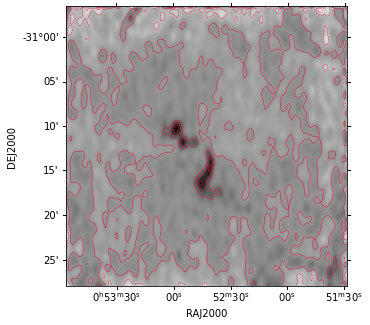

In [28]:
wcs = WCS(assoc_data[0].header).celestial
fig = plt.figure(figsize=(6.3, 5.04))
ax = fig.add_axes([0.17, 0.17,
                   0.77, 0.77], projection=wcs)
ax.imshow(assoc_data[0].data[150, :, :], cmap='gist_gray_r')
ax.contour(assoc_data[0].data[150, :, :], colors='crimson', linewidths=0.5)
ax.set_xlabel('RAJ2000')
ax.set_ylabel('DEJ2000')

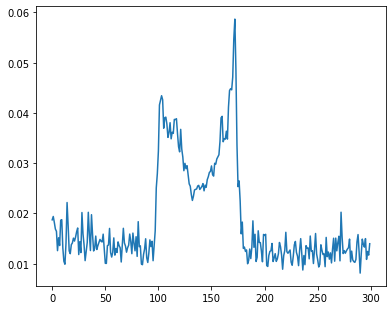

In [29]:
spec = np.max(assoc_data[0].data, axis=(1,2))
fig = plt.figure(figsize=(6.3, 5.04))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot(spec)

Et voila a beautiful HI double horn, which we can use for further analysis ;)